## OT - we want to use OT concept to find pairs btwn ctrl and treatment, then using VAE get the transformations. Should be a good baseline.

### Imports

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import scanpy as scp
import pandas as pd
import numpy as np
import catboost as cb
from tqdm import tqdm
from scipy import sparse
from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from collections import Counter
import lightgbm as lgb
import matplotlib.pyplot as plt
import umap
from sklearn.model_selection import StratifiedKFold

import ot
from sklearn.decomposition import PCA

### Magics

In [3]:
GENE_PER_CELL_BINNING = False
N_BINS = 1000
N_ITER = 50
TOP_N_GENES = 5000

### Step 0

In [4]:
adata = scp.read_h5ad('./data/Norman_2019/norman_umi_go/perturb_processed.h5ad')

In [5]:
## Following the scGPT paper, we bin the genes within cell. 

def bin_nonzero_values(arr, num_bins):
    # Filter out non-zero values
    nonzero_vals = arr[arr != 0]
    
    # Calculate bin edges
    bin_edges = np.linspace(nonzero_vals.min(), nonzero_vals.max(), num_bins)
    
    # Bin the values
    binned_values = np.zeros_like(arr)
    binned_nonzero = np.digitize(nonzero_vals, bin_edges)
    binned_values[arr != 0] = binned_nonzero
    
    return binned_values

# Example usage
arr = np.random.randint(low=0, high=100, size=100)
num_bins = 3
binned_values = bin_nonzero_values(arr, num_bins)
print(set(binned_values))

{1, 2, 3}


In [6]:
scp.pp.normalize_total(adata, exclude_highly_expressed=True)
scp.pp.log1p(adata)
scp.pp.highly_variable_genes(adata, n_top_genes=TOP_N_GENES,subset=True)

In [7]:
if GENE_PER_CELL_BINNING:
    tempy = adata.X.toarray()
    
    for c in tqdm(range(adata.X.shape[0])):
        tempy[c,:] = bin_nonzero_values(tempy[c,:], N_BINS)
    
    adata.X = sparse.csr_matrix(tempy)
    del tempy

In [8]:
y = adata.obs.condition.values.astype(str)
X = adata.X.toarray()

In [21]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution='normal',random_state=42,)

In [22]:
gene_num_map = ['ctrl']
y_processed = []

for rec in tqdm(y):
    y_processed.append([])
    comps = rec.split('+')
    for c in comps:
        if c not in gene_num_map:
            gene_num_map.append(c)
        y_processed[-1].append(gene_num_map.index(c))
    if len(y_processed[-1])<2:
        y_processed[-1].append(gene_num_map.index('ctrl'))

100%|██████████| 91205/91205 [00:00<00:00, 280631.76it/s]


In [23]:
def pair_records_optimal_transport(set1, set2):
    """
    Pairs records from set1 with records from set2 using the optimal transport concept.
    Records from set2 can be used multiple times if needed.

    Args:
    - set1 (np.ndarray): First 2D array of records (shape: n1 x features).
    - set2 (np.ndarray): Second 2D array of records (shape: n2 x features).

    Returns:
    - pairs (list of tuples): List of index pairs (i, j) where i is the index
      from set1 and j is the index from set2 that are paired.
    """

    # Ensure the inputs are numpy arrays
    set1 = np.array(set1)
    set2 = np.array(set2)

    # Compute the cost matrix (Euclidean distance between records)
    cost_matrix = ot.dist(set1, set2, metric='euclidean')

    # Compute the optimal transport plan using linear programming
    n1, n2 = set1.shape[0], set2.shape[0]
    a = np.ones(n1) / n1  # uniform distribution on set1
    b = np.ones(n2)  # flexible distribution on set2

    # Normalize b to sum to the same total mass as a
    b = b / b.sum() * a.sum()

    transport_plan = ot.emd(a, b, cost_matrix)

    # Extract pairs based on the transport plan
    pairs = []
    for i in range(n1):
        j = np.argmax(transport_plan[i])
        pairs.append((i, j))

    return pairs

    
# Example usage
set1 = np.random.rand(20, 5000)  # 100 records with 5000 features each
set2 = np.random.rand(100, 5000)  # 100 records with 5000 features each

pairs = pair_records_optimal_transport(set1, set2)
print(pairs)

[(0, 3), (1, 87), (2, 37), (3, 0), (4, 5), (5, 12), (6, 23), (7, 7), (8, 46), (9, 2), (10, 10), (11, 15), (12, 34), (13, 13), (14, 27), (15, 29), (16, 8), (17, 35), (18, 1), (19, 4)]


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y_processed, 
                                                  test_size=0.3, 
                                                  random_state=42,
                                                  )

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, 
                                                  random_state=42,
                                                  )

In [25]:
def vae_data_prep(X, y):
    # Convert list of lists to a set of tuples to find unique classes
    unique_classes = set(tuple(sorted(yi)) for yi in y)
    
    output_X = []
    output_Y = []
    labels = []
    
    # Convert y to a list of tuples for easier comparison
    y_tuples = [tuple(sorted(yi)) for yi in y]
    
    for c in tqdm(unique_classes):
        
        set1_indices = [i for i, yi in enumerate(y_tuples) if yi == c]
        set2_indices = [i for i, yi in enumerate(y_tuples) if yi == (0,0)]
        
        set1 = X[set1_indices]
        set2 = X[set2_indices]
        
        pairs = pair_records_optimal_transport(set1, set2)
        
        for p in pairs:
            output_X.append(set2[p[1]])
            output_Y.append(set1[p[0]])
            labels.append(c)
    
    output_X = np.array(output_X)
    output_Y = np.array(output_Y)
    
    return output_X, output_Y, labels

In [26]:
X_trainv, Y_trainv, labels_trainv = vae_data_prep(X_train, y_train)
X_valv, Y_valv, labels_valv = vae_data_prep(X_val, y_val)
X_testv, Y_testv, labels_testv = vae_data_prep(X_test, y_test)

 27%|██▋       | 63/237 [00:19<00:43,  4.01it/s]/hpcfs/users/a1234104/miniconda3/envs/py310torch/lib/python3.10/site-packages/ot/lp/__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
100%|██████████| 237/237 [00:20<00:00, 11.70it/s]


In [27]:
pca = PCA(n_components=0.99)
X_train_r = X_trainv #pca.fit_transform(X_trainv)
X_val_r = X_valv#pca.transform(X_valv)
X_test_r = X_testv#pca.transform(X_testv)

In [28]:
Y_train_r = Y_trainv#pca.transform(Y_trainv)
Y_val_r = Y_valv#pca.transform(Y_valv)
Y_test_r = Y_testv#pca.transform(Y_testv)

In [29]:
qt.fit(X_trainv)
X_train_r = qt.transform(X_trainv)
X_test_r = qt.transform(X_testv)
X_val_r = qt.transform(X_valv)

Y_train_r = qt.transform(Y_trainv)
Y_test_r = qt.transform(Y_testv)
Y_val_r = qt.transform(Y_valv)

In [30]:
# model = LGBMClassifier(verbose=-1, n_jobs=10)
# model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='auc_mu',    callbacks=[
#         lgb.early_stopping(stopping_rounds=100),
#         lgb.log_evaluation(1)
#     ])

In [31]:
device = 'cuda:0'

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx]

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dims):
        super(VAE, self).__init__()

        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)
        
        self.encoder = self.build_encoder(input_dim, latent_dim, hidden_dims)
        self.decoder = self.build_decoder(latent_dim, input_dim, hidden_dims)
        
    def build_encoder(self, input_dim, latent_dim, hidden_dims):
        layers = []
        for h_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.4)) 
            input_dim = h_dim
        return nn.Sequential(*layers)
    
    def build_decoder(self, latent_dim, output_dim, hidden_dims):
        layers = []
        hidden_dims.reverse()
        for h_dim in hidden_dims:
            layers.append(nn.Linear(latent_dim, h_dim))
            layers.append(nn.ReLU())
            latent_dim = h_dim
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        layers.append(nn.Sigmoid())
        return nn.Sequential(*layers)

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x, perturbs = []):
        mu, logvar = self.encode(x.to(device))
        z = self.reparameterize(mu, logvar)
        z_p = z.clone()
        #perturbation introduced at the latent space level
        for pert_n in perturbs:
            perturbs_tensor = pert_n.to(device)
            non_zero_batch_indices = perturbs_tensor.nonzero(as_tuple=False)
            z_p[non_zero_batch_indices, perturbs_tensor[non_zero_batch_indices]] += 150
        
        pert_x = self.decode(z_p)
        recon_x = self.decode(z)
        
        return pert_x, recon_x, mu, logvar
        
import matplotlib.pyplot as plt
from IPython.display import clear_output

def vae_loss(pert_x, y, recon_x, x, mu, logvar):
    x = x.to(device)
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    pert_loss = nn.functional.mse_loss(pert_x, y, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss, pert_loss, kl_loss

def train_vae(model, train_loader, val_loader, epochs, learning_rate=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        total_train_recon_loss = 0
        total_train_pert_loss = 0
        total_train_kl_loss = 0
        for batch_ctrl, batch_pert, pert_labels in train_loader:
            optimizer.zero_grad()
            batch_ctrl = batch_ctrl.to(device)
            batch_pert = batch_pert.to(device)
                        
            pert_x, recon_x, mu, logvar = model(batch_ctrl, pert_labels)
            
            z = model.reparameterize(mu, logvar)
            recon_loss, pert_loss, kl_loss = vae_loss(pert_x, batch_pert, recon_x, batch_ctrl, mu, logvar)
            loss = recon_loss + pert_loss + kl_loss
            loss.backward()
            optimizer.step()
            total_train_recon_loss += recon_loss.item()
            total_train_pert_loss += pert_loss.item()
            total_train_kl_loss += kl_loss.item()
        
        avg_train_recon_loss = total_train_recon_loss / len(train_loader.dataset)
        avg_train_pert_loss = total_train_pert_loss / len(train_loader.dataset)
        avg_train_kl_loss = total_train_kl_loss / len(train_loader.dataset)
        train_losses.append((avg_train_recon_loss, avg_train_pert_loss, avg_train_kl_loss))
        
        model.eval()
        total_val_recon_loss = 0
        total_val_pert_loss = 0
        total_val_kl_loss = 0
        with torch.no_grad():
            for batch_ctrl, batch_pert, pert_labels in val_loader:

                batch_ctrl = batch_ctrl.to(device)
                batch_pert = batch_pert.to(device)
                                
                pert_x, recon_x, mu, logvar = model(batch_ctrl, pert_labels)
                z = model.reparameterize(mu, logvar)
                recon_loss, pert_loss, kl_loss = vae_loss(pert_x, batch_pert, recon_x, batch_ctrl, mu, logvar)
                total_val_recon_loss += recon_loss.item()
                total_val_pert_loss += pert_loss.item()
                total_val_kl_loss += kl_loss.item()
        
        avg_val_recon_loss = total_val_recon_loss / len(val_loader.dataset)
        avg_val_pert_loss = total_val_pert_loss / len(val_loader.dataset)
        avg_val_kl_loss = total_val_kl_loss / len(val_loader.dataset)
        val_losses.append((avg_val_recon_loss, avg_val_pert_loss, avg_val_kl_loss))
        
        #print(f'Epoch {epoch+1}, Train Recon Loss: {avg_train_recon_loss:.4f}, Train Pert Loss: {avg_train_pert_loss:.4f}, Train KL Loss: {avg_train_kl_loss:.4f}, Val Recon Loss: {avg_val_recon_loss:.4f}, Val Pert Loss: {avg_val_pert_loss:.4f}, Val KL Loss: {avg_val_kl_loss:.4f}')
        
        model.train()

        # Plotting the losses
        clear_output(wait=True)
        fig, ax = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(10, 7))
        
        ax[0].plot([x[0] for x in train_losses], label='Train Recon Loss')
        ax[1].plot([x[1] for x in train_losses], label='Train Pert Loss')
        ax[2].plot([x[2] for x in train_losses], label='Train KL Loss')
        # Plot validation losses
        ax[0].plot([x[0] for x in val_losses], label=f'Val Recon Loss; Best: {np.argmin([x[0] for x in val_losses])}')
        ax[1].plot([x[1] for x in val_losses], label=f'Val Pert Loss; Best: {np.argmin([x[1] for x in val_losses])}')
        ax[2].plot([x[2] for x in val_losses], label=f'Val KL Loss; Best: {np.argmin([x[2] for x in val_losses])}')
        
        # Add legends
        ax[0].legend()
        ax[1].legend()
        ax[2].legend()
        plt.show()
        # Add titles


In [58]:
class CustomDataset(Dataset):
    def __init__(self, X, Y, labels):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
        self.labels = labels
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx], self.labels[idx]


train_dataset = CustomDataset(X_trainv[:,:], Y_trainv[:,:], labels_trainv)
val_dataset = CustomDataset(X_valv[:,:], Y_valv[:,:], labels_valv)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

input_dim = X_trainv.shape[1]
latent_dim = 256
hidden_dims = [1024, 512, 256]
epochs = 800
learning_rate = 1e-3

vae = VAE(input_dim, latent_dim, hidden_dims).to(device)

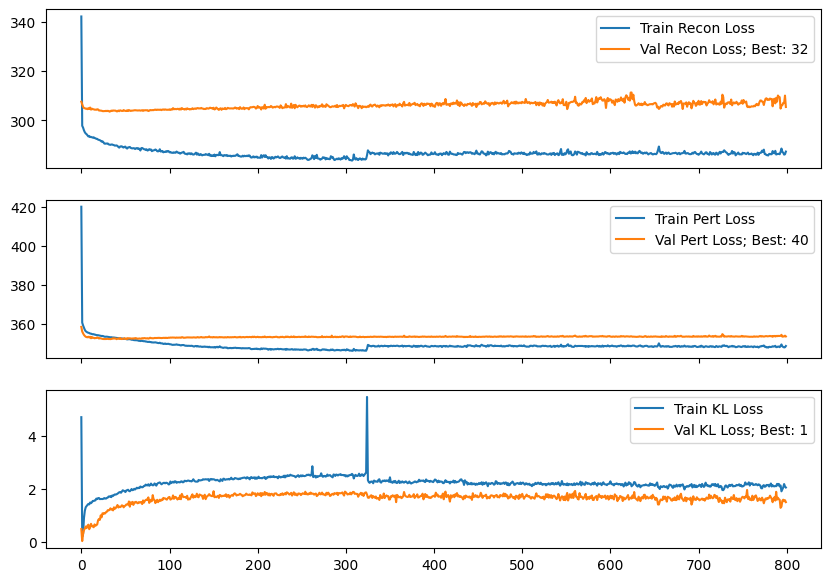

In [59]:
train_vae(vae, train_loader, val_loader, epochs, learning_rate)

# For testing, you can run the model in evaluation mode
vae.eval()
with torch.no_grad():
    for batch_ctrl, batch_pert, pert_labels in val_loader:
        pert_x, recon_x, mu, logvar = vae(batch_ctrl, pert_labels)
        z = vae.reparameterize(mu, logvar)
        break

In [42]:
zs = []
labels0 = []
labels1 = []
vae.eval()
with torch.no_grad():
    for batch_ctrl, batch_pert, pert_labels in tqdm(val_loader):
        pert_x, recon_x, mu, logvar = vae(batch_ctrl, pert_labels)
        z = vae.reparameterize(mu, logvar)
        labels0.append(pert_labels[0].numpy())
        labels1.append(pert_labels[1].numpy())
        zs.append(z.detach().cpu().numpy())
        break

  0%|          | 0/25 [00:03<?, ?it/s]


In [43]:
zsnp = np.concatenate(zs)

In [44]:
labels0 = np.concatenate(labels0)
labels1 = np.concatenate(labels1)

In [45]:
labels0[0], labels1[0]

(9, 70)

In [53]:
labels0[-2], labels1[-2]

(0, 69)

In [47]:
np.argsort(abs(pert_x.detach().cpu().numpy() - recon_x.detach().cpu().numpy()), axis=1)

array([[3333, 4390, 4395, ..., 2382, 2158, 3687],
       [2612, 2120, 4770, ..., 2382, 2158, 3687],
       [3468, 2766, 2783, ..., 1312, 2158, 2630],
       ...,
       [3939, 1591, 3468, ..., 4977, 2061, 2158],
       [ 969,  641, 3340, ..., 4977, 2061, 2158],
       [2639, 4818, 3572, ..., 1685, 4635, 1684]])

### Manual Explore

In [48]:
batch_pert[0,920], batch_ctrl[0,920]

(tensor(0.6172), tensor(0.))

In [48]:
batch_pert[0,920], batch_ctrl[0,920]

(tensor(0.6172), tensor(0.))

In [49]:
pert_x[0,920],recon_x[0,920]

(tensor(0.1058, device='cuda:0'), tensor(0.0020, device='cuda:0'))

In [54]:
gene_num_map[9], gene_num_map[69], gene_num_map[70]

('TGFBR2', 'BPGM', 'SAMD1')

In [56]:
adata.var.iloc[[4977,2158]].gene_name

gene_id
ENSG00000182871    COL18A1
ENSG00000158578      ALAS2
Name: gene_name, dtype: category
Categories (5000, object): ['A2M', 'AAED1', 'AAK1', 'AAMDC', ..., 'ZPR1', 'ZRANB2', 'ZSCAN16-AS1', 'ZWINT']

In [51]:
adata.var.iloc[[3687,2158]].gene_name

gene_id
ENSG00000206172     HBA1
ENSG00000158578    ALAS2
Name: gene_name, dtype: category
Categories (5000, object): ['A2M', 'AAED1', 'AAK1', 'AAMDC', ..., 'ZPR1', 'ZRANB2', 'ZSCAN16-AS1', 'ZWINT']

In [49]:
pert_x[0,920],recon_x[0,920]

(tensor(0.1058, device='cuda:0'), tensor(0.0020, device='cuda:0'))

In [50]:
gene_num_map[9], gene_num_map[70]

('TGFBR2', 'SAMD1')

In [51]:
adata.var.iloc[[3687,2158]].gene_name

gene_id
ENSG00000206172     HBA1
ENSG00000158578    ALAS2
Name: gene_name, dtype: category
Categories (5000, object): ['A2M', 'AAED1', 'AAK1', 'AAMDC', ..., 'ZPR1', 'ZRANB2', 'ZSCAN16-AS1', 'ZWINT']